In [1]:
from counter import counter
cc = counter('count-cooc-top20k-strat30-WoS-econ')

Loading count-cooc-top20k-strat30-WoS-econ from disk...


In [2]:
import numpy as np

In [3]:
from matplotlib import pyplot as plt

In [4]:
len(cc.items('t'))

1500

# the math

$$ \frac{ \text{count-t}(a) }{ \sum \text{count-t}(a) } = 1 $$
$$ \sum_b{ \text{count-t.t}(a,b) } = 5 \sum \text{count-t}(a) $$

$$ P( \text{b shows up after a} ) = 1 - \prod_N{ \left[ 1 - P( w_{j+N} = b | w_j = a ) \right] } $$

$$ P( w_{j+N} = b | w_j = a ) = ?? $$

$$ \frac{ \text{count-t.t}(a,b) }{ \text{count-t}(a) } = \sum_{N=1}^5 P( w_{j+N} = b | w_j = a ) \in [0, 5] $$

Now I want to measure how surprising a given connection is compared to the individual propensities.
Something similar to // independence indicates that

$$P(A \& B) = P(A) * P(B|A) = P(A) * P(B)$$

Where the last equality expresses the independence assumption. The extent to which the leftmost and rightmost quantities differ is a good measure for the relevance of a single tie between events.
So, assume $a$ and $b$ are independent events. From above we know that

$$P(a \to b) = \prod_N{ \left[ 1 - P( w_{j+N} = b | w_j = a ) \right] }$$

And by independence this is just

$$ \prod_N{ \left[ 1 - P( w_{j+N} = b ) \right] } $$

$$ P( w_{j+N} = b ) = \text{count-t}(b) * 5 $$

So we almost get what we want... Let's try another combo of formulas...

$$ \frac{ \text{count-t.t}(a,b) }{ \text{count-t}(a) } = \sum_{N=1}^5 P( w_{j+N} = b | w_j = a ) $$
$$ = \sum_{N=1}^5 P( w_{j+N} = b ) = \sum_{N=1}^5 \frac{ \text{count-t}(b) }{ \sum_b{\text{count-t}(b)} } = \frac{ 5 * \text{count-t}(b) }{ \sum_b{\text{count-t}(b)} }  $$

By this math the relevant ratio is

$$ \frac{ \text{count-t.t}(a,b) * \sum_b{\text{count-t}(b)} }{ \text{count-t}(a) * \text{count-t}(b) } = 5 $$

# generate the network

In [5]:
cc.counts.keys()

dict_keys([('fy', 't'), ('fj', 't'), ('fy',), ('t',), ('fj',), ('t1', 't2'), ('fy', 't1', 't2')])

In [6]:
tot = cc.counts[('t',)].sum()
terms = cc.items('t')

In [7]:
rats = []
pairs = []

for t1 in terms:
    for t2 in terms:
        if t1 == t2:
            continue
        
        ca = cc(t=t1)
        cb = cc(t=t2)
        cab = cc(t1=t1, t2=t2)
        
        if cab < 10 or ca < 10 or cb < 10:
            continue

        rat = tot * cab / (ca * cb)
        pairs.append( (cc.ids['t'][t1], cc.ids['t'][t2]) )
        rats.append( rat )

In [8]:
rats = np.array(rats)

In [9]:
np.argwhere( rats > 250 ).shape

(1173, 1)

In [10]:
np.argwhere( rats < 250 ).shape

(11410, 1)

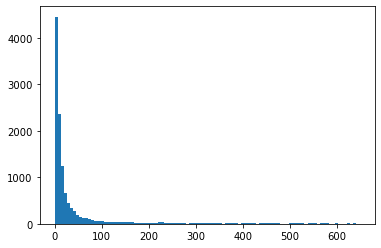

In [11]:
plt.hist( rats[(rats<250+400)&(rats>0)], bins=100 );

In [12]:
np.mean(rats)

101.46262940701719

In [13]:
np.quantile(rats, 0.9)

226.89770129716564

In [14]:
from random import sample

In [15]:
tops = np.argwhere( rats > np.quantile(rats, 0.99) ).flatten()
tops = list(tops)

for i in sample( tops, 100 ):
    ai, bi = pairs[i]
    at = [x for x,i in cc.ids['t'].items() if i==ai][0]
    bt = [x for x,i in cc.ids['t'].items() if i==bi][0]
    
    ac = cc.counts[('t',)][ai]
    bc = cc.counts[('t',)][bi]
    abc = cc.counts[('t1','t2')][(ai,bi)]
    bac = cc.counts[('t1','t2')][(bi,ai)]
    print( (at, bt, rats[i], ac, bc, abc, bac) )

('the-dynamics', 'dynamics-of', 2337.483660130719, 77, 153, 1, 0)
('notes', 'notes-on', 2154.4277108433735, 166, 121, 0, 2)
('with-special', 'special', 1986.861111111111, 105, 180, 0, 1)
('approaches', 'approaches-to', 2569.358938933407, 141, 77, 0, 0)
('there', 'there-a', 2263.512658227848, 158, 63, 0, 2)
('lessons', 'lessons-from', 2432.891156462585, 147, 96, 1, 0)
('the-business', 'business-cycle', 2218.475538389513, 89, 96, 0, 1)
('foreign-direct', 'direct-investment', 3019.87252008526, 107, 114, 1, 1)
('the-problem', 'problem-of', 2008.606710829493, 124, 168, 0, 0)
('special-reference', 'reference', 2384.233333333333, 91, 150, 0, 0)
('terms', 'terms-of', 3030.8050847457625, 118, 88, 0, 1)
('importance', 'importance-of', 2861.08, 125, 112, 3, 0)
('in-relation', 'relation-to', 3193.1696428571427, 67, 112, 2, 12)
('wage-differentials', 'differentials', 2360.375771769214, 61, 154, 0, 0)
('developments', 'developments-in', 2649.1481481481483, 135, 83, 0, 1)
('assessment', 'assessment-o

# dump network

In [16]:
import networkx as nx

In [85]:
rats = np.array(rats)
cutoff = np.quantile(rats[rats>0], 0.5)
cutoff

11.481913464964313

In [86]:
G = nx.DiGraph()

edges = []

for i, r in enumerate(rats):
    if r < cutoff:
        continue
    
    ai,bi = pairs[i]
    at = [x for x,i in cc.ids['t'].items() if i==ai][0]
    bt = [x for x,i in cc.ids['t'].items() if i==bi][0]
    
    edges.append( [at,bt,r] )

G.add_weighted_edges_from(edges)

In [87]:
edges,weights = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(G,'weight').items()])

In [88]:
deg = np.array(list(x[1] for x in G.degree()))

In [89]:
DEG_CUTOFF = 2
print(
    np.where( deg >= DEG_CUTOFF )[0].shape,
    np.where( deg < DEG_CUTOFF )[0].shape
)

G.remove_nodes_from( list(np.where( deg < DEG_CUTOFF )[0]) )

(1312,) (132,)


In [90]:
%pip install infomap

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\amcga\envs\citation-deaths\scripts\python.exe -m pip install --upgrade pip' command.


In [91]:
i,j,w

(12582, 'women', 120.89070422535211)

In [92]:
from infomap import Infomap

# Command line flags can be added as a string to Infomap
im = Infomap("--two-level --directed")

# Add weight as optional third argument
for i,j,w in G.edges(data='weight'):
    im.add_link(cc.ids['t'][i], cc.ids['t'][j], weight=w)

In [93]:
# Run the Infomap search algorithm to find optimal modules
im.run()

print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

Found 225 modules with codelength: 5.543946516844766


In [94]:
n2mod = im.get_modules(1)

In [95]:
R, C = 5, 5

nodes_list = [
    [n for n,mc in n2mod.items() if mc==mod ]
    for mod in set(n2mod.values())
]
nodes_list = sorted(nodes_list, key=lambda x:-len(x))

In [96]:
[len(x) for x in nodes_list[:5]]

[33, 27, 24, 23, 22]

In [97]:
id2t = {i:t for t,i in cc.ids['t'].items()}

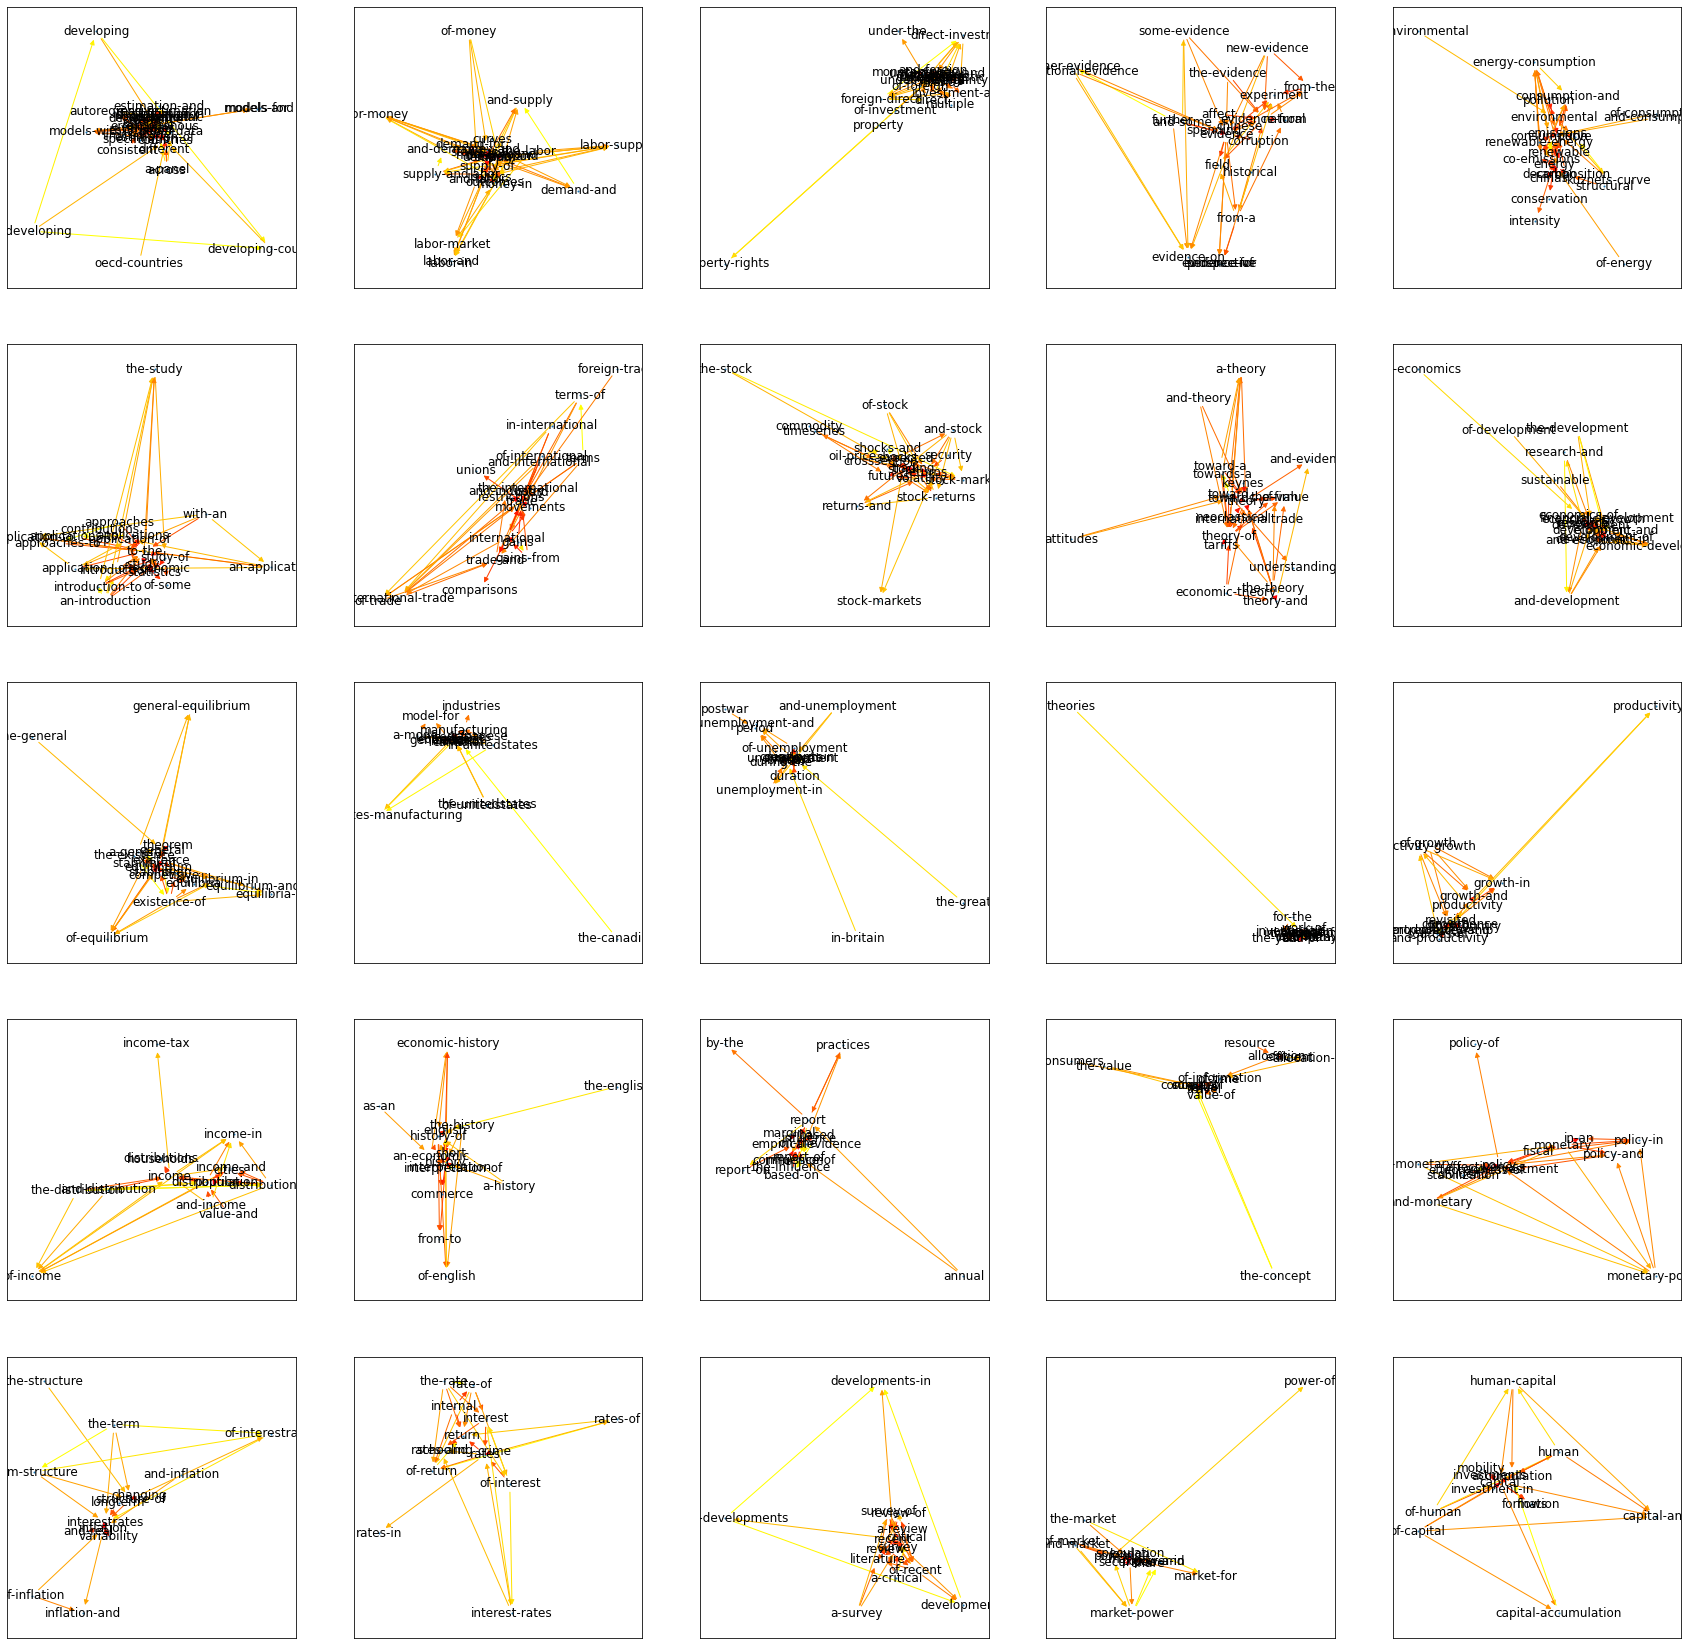

In [98]:
plt.figure(figsize=(6*R,6*C))

for i,Gcomp_nodesi in enumerate(nodes_list[:R*C]):
    
    Gcomp_nodes = [id2t[gci] for gci in Gcomp_nodesi]
    
    plt.subplot(R,C,i+1)
    Gcomp = nx.subgraph(G, Gcomp_nodes)
    pos = nx.kamada_kawai_layout(Gcomp)

    edges,weights = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(Gcomp,'weight').items()])

    c = np.log(weights)
    c /= c.max()

    nx.draw_networkx_edges(Gcomp,pos,edgelist=edges,edge_cmap=plt.cm.autumn,edge_color=c)
    nx.draw_networkx_nodes(Gcomp,pos,node_size=1)
    nx.draw_networkx_labels(Gcomp,pos)

# just try outputting & use Gephi

In [144]:
from csv import writer

In [146]:
with open('second_cooc.csv', 'w', encoding='utf8') as outf:
    
    w = writer(outf)
    w.writerow(['Source', 'Target', 'Weight'])
    
    for (ti1, ti2, wt) in G.edges(data='weight'):
        w.writerow([ti1,ti2,wt])

Loading this coocurrence network first_cooc.csv into Gephi produced good results.

+ there is a cluster of single-letter words a -> d -> etc... which should be ignored
+ there are many words which show up equally in articles from a given journal (i.e. extremely high entropy across journals) which should be removed
+ there are many words which show up equally in all articles, usually regarding the flow, that can be removed
+ the window should be increased, and should be modified when terms are encountered, which are always followed by the second word of the term
+ it's actually good that a given term points strongly to a word that's contained in it (that's the immediate next word)
+ there are interpretable results already, but it's clear that 1k words just isn't enough. t1.t2 is only 24M with 1k words. It's not storage, it's only memory?
+ I also need to store fy.t1.t2
+ I need to upload the whole dataset